In [2]:
import numpy as np
import pandas as pd 

In [3]:
covid = pd.read_csv('Covid Data.csv')
covid.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


### 数据预处理

In [4]:
# 将已经死亡的患者标记为 1，未死亡的患者标记为2
# 这列数据将作为判断患者是否高危的label，1（死亡患者）代表高危
covid['DEATH'] = [2 if row=='9999-99-99' else 1 for row in covid['DATE_DIED']]
covid['DEATH'].value_counts()

2    971633
1     76942
Name: DEATH, dtype: int64

In [5]:
# 每列缺失数据所占的比例
for col in covid.columns :
    # 97 98和 99 是缺失数据
    print('{:<20} => {:>10.2f}%'.format(col, len(covid[(covid[col]==98) | (covid[col]==99) |
                                                       (covid[col]==97)])/len(covid)*100))

USMER                =>       0.00%
MEDICAL_UNIT         =>       0.00%
SEX                  =>       0.00%
PATIENT_TYPE         =>       0.00%
DATE_DIED            =>       0.00%
INTUBED              =>      81.62%
PNEUMONIA            =>       1.53%
AGE                  =>       0.03%
PREGNANT             =>      50.28%
DIABETES             =>       0.32%
COPD                 =>       0.29%
ASTHMA               =>       0.28%
INMSUPR              =>       0.32%
HIPERTENSION         =>       0.30%
OTHER_DISEASE        =>       0.48%
CARDIOVASCULAR       =>       0.29%
OBESITY              =>       0.29%
RENAL_CHRONIC        =>       0.29%
TOBACCO              =>       0.31%
CLASIFFICATION_FINAL =>       0.00%
ICU                  =>      81.64%
DEATH                =>       0.00%


In [5]:
covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU', 'DEATH'],
      dtype='object')

In [6]:
# 去除缺失数据
cols = ['PNEUMONIA','DIABETES', 'COPD', 'ASTHMA', 'INMSUPR','HIPERTENSION', 
        'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY','RENAL_CHRONIC', 'TOBACCO']
for col in cols :
    covid = covid[(covid[col] == 1)|(covid[col] == 2)]

In [7]:
# 这三列缺失值太多，直接去除
covid.drop(columns=['INTUBED','ICU','DATE_DIED'],inplace=True)

Text(0.5, 1.0, '变量间的相关系数')

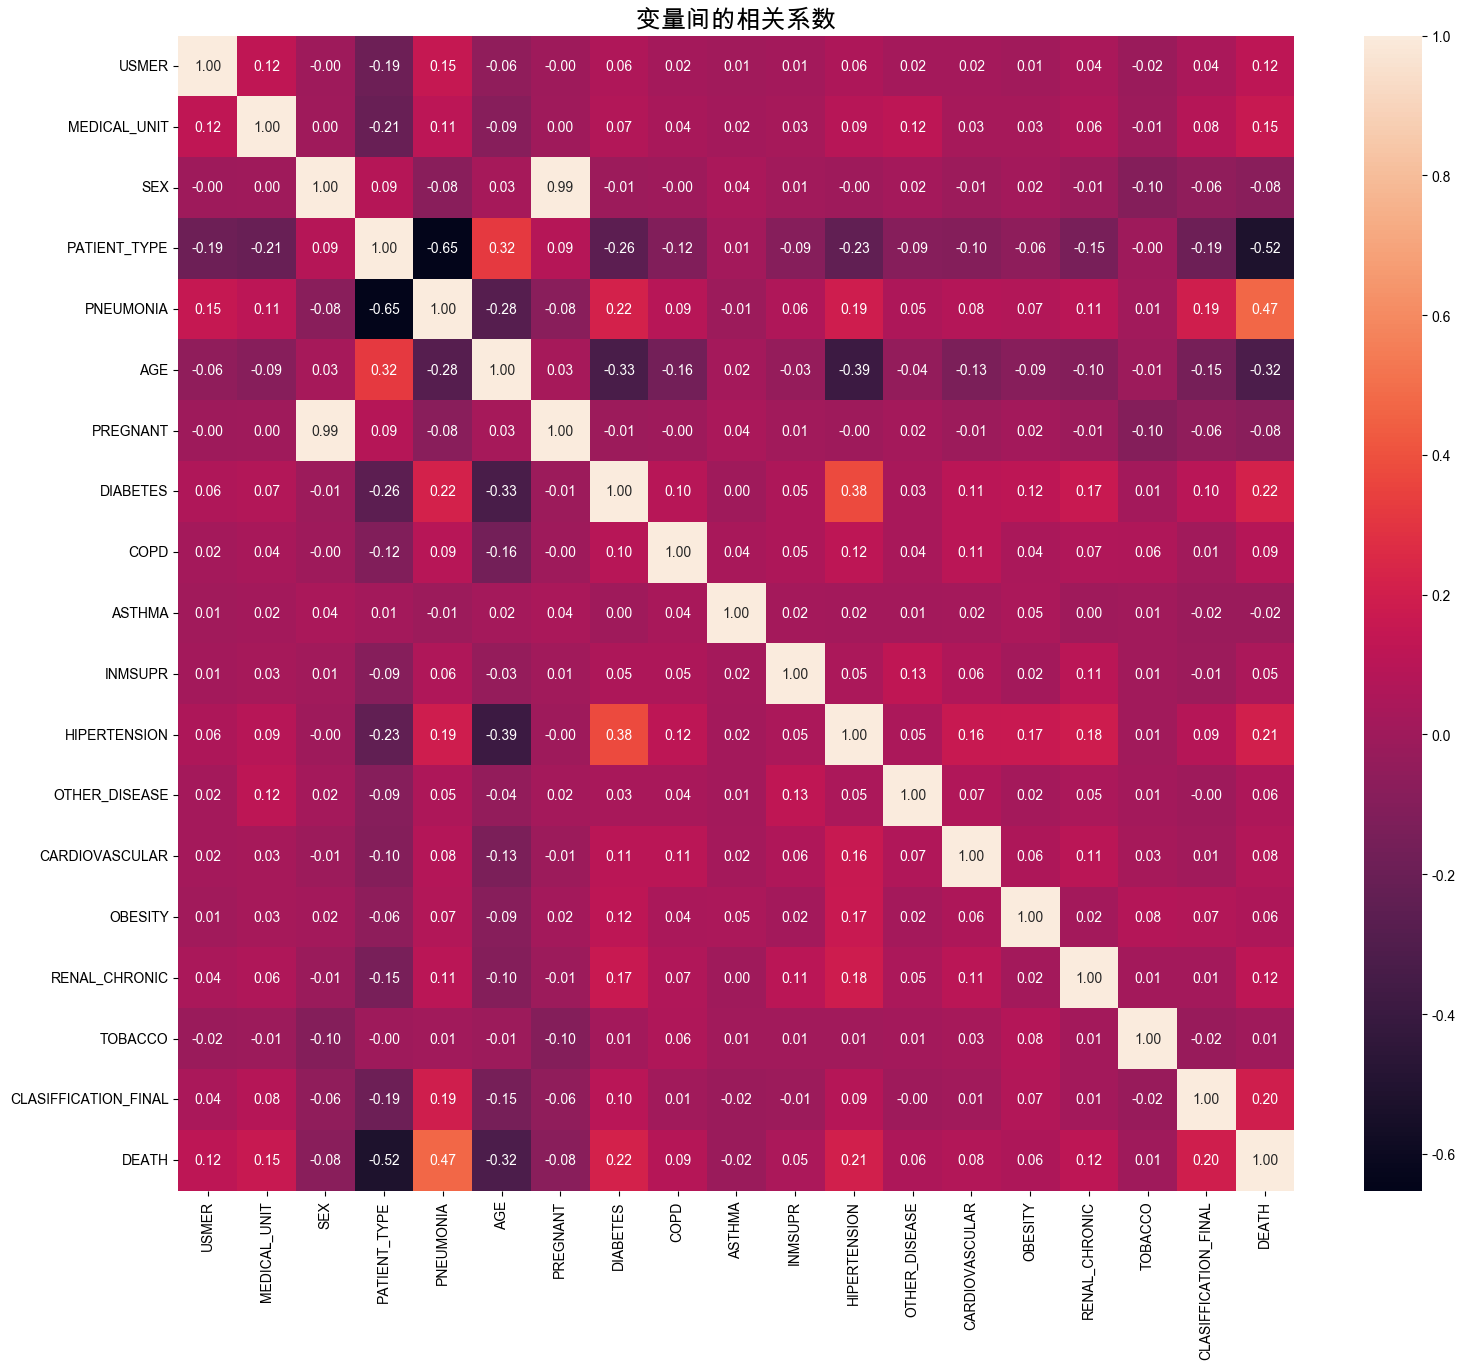

In [8]:
# 绘制热力图，展示变量的相关系数矩阵
import  matplotlib.pyplot as plt
import seaborn as sns
# 解决中文乱码
plt.rcParams['font.family'] = ['Arial Unicode MS','Microsoft YaHei','SimHei','sans-serif']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(18,15))
sns.heatmap(covid.corr(), annot=True, fmt='.2f')
plt.title('变量间的相关系数', fontsize=18)

In [8]:
# 对年龄进行归一化
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
covid['AGE'] = standard_scaler.fit_transform(covid.loc[:,['AGE']])

In [9]:
# 按照8:2划分数据集与训练集
y = covid['DEATH']
x = covid.drop('DEATH', axis=1)
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=42)

print('Train X :', train_x.shape)
print('Test X :', test_x.shape)
print('Train Y :', train_y.shape)
print('Test Y :', test_y .shape)

Train X : (820121, 18)
Test X : (205031, 18)
Train Y : (820121,)
Test Y : (205031,)


### 随机森林模型

In [11]:
from sklearn.ensemble import RandomForestClassifier
# 使用随机森林分类器，基评估器的数量设置为100
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_x, train_y)

RandomForestClassifier()

In [12]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score  # 导入模型评估工具包

Y_train_pred = random_forest.predict(train_x)  # 进行训练集模型预测
Y_pred = random_forest.predict(test_x)  # 进行验证集模型预测
print("-----------------训练集性能评估-------------------")
# 进行模型评估：通过准确率、查准率、查全率、F1值，并分为训练集评估和验证集评估
print("训练集准确率: {:.2f}%".format(accuracy_score(train_y, Y_train_pred) * 100))
print("训练集查准率: {:.2f}%".format(precision_score(train_y, Y_train_pred) * 100))  # 打印训练集查准率
print("训练集查全率: {:.2f}%".format(recall_score(train_y, Y_train_pred) * 100))  # 打印训练集查全率
print("训练集F1值: {:.2f}%".format(f1_score(train_y, Y_train_pred) * 100))  # 打印训训练集F1值
print("----------------验证集性能评估--------------------")
print("验证集准确率: {:.2f}%".format(accuracy_score(test_y, Y_pred) * 100))
print("验证集查准率: {:.2f}%".format(precision_score(test_y, Y_pred) * 100))  # 打印验证集查准率
print("验证集查全率: {:.2f}%".format(recall_score(test_y, Y_pred) * 100))  # 打印验证集查全率
print("验证集F1值: {:.2f}%".format(f1_score(test_y, Y_pred) * 100))  # 打印验证集F1值

-----------------训练集性能评估-------------------
训练集准确率: 96.65%
训练集查准率: 80.33%
训练集查全率: 71.78%
训练集F1值: 75.82%
----------------验证集性能评估--------------------
验证集准确率: 93.51%
验证集查准率: 55.45%
验证集查全率: 47.89%
验证集F1值: 51.39%


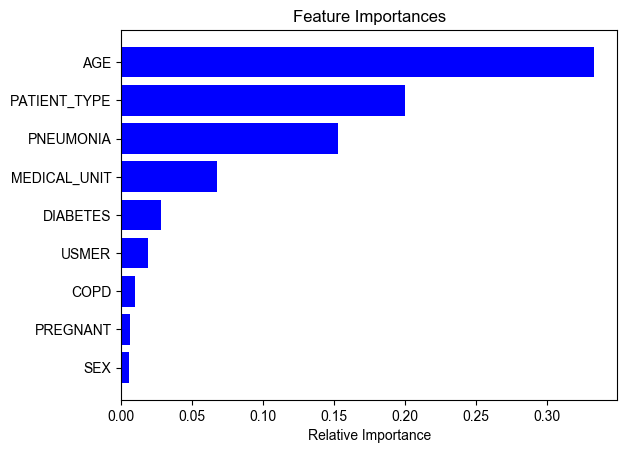

In [13]:
# 绘制特征重要性
features = covid.columns
importances = random_forest.feature_importances_
indices = np.argsort(importances[0:9])  # top 10 的特征
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Kmeans聚类

In [10]:
import pandas as pd
# 导入sklearn中的kmeans
from sklearn.cluster import KMeans
# 设置类数k
k = 2
# 设置最大迭代次数
iteration = 500
# 创建kmeans对象
model = KMeans(n_clusters=k,max_iter=iteration)
# 使用数据训练训练model
model.fit(x)
# 每个类别样本个数
pd.Series(model.labels_).value_counts()

1    515111
0    510041
dtype: int64

In [11]:
# 每个类别的聚类中心
pd.DataFrame(model.cluster_centers_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.643393,8.979327,1.000000,1.152543,1.89283,-0.028701,1.984627,1.883992,1.986293,1.962642,1.985907,1.845236,1.969769,1.981892,1.840230,1.983886,1.947020,5.400932
1,1.640829,9.007818,1.993836,1.221498,1.83899,0.028419,97.006164,1.877219,1.985663,1.977785,1.987575,1.843449,1.977263,1.978859,1.853484,1.980330,1.891959,5.182421
